# 4 Preprocessing and Training Data Development 

## Table of Contents:

* [4.1 Introduction](#4.1)
* [4.2 Import Packages](#4.2)
* [4.3 Load the Data](#4.3)
* [4.4 Train/Test Split](#4.4)
    * [4.4.1 Exporting the Data](#4.4.1)
* [4.5 Preprocessing with Scaling, PCA, and K-Means Clustering](#4.5)
* [4.6 Upsampling with SMOTE](#4.6)
    * [4.6.1 Exporting the Data](#4.6.1)
* [4.7 Baseline Model: Logistic Regression](#4.7)
* [4.8 Summary and Next Steps](#4.8)

## 4.1 Introduction<a id='4.1'></a>

In our previous notebook, "Step 3 - Exploratory Data Analysis", we used PCA and t-SNE for dimensionality reduction and visualizating the data. We also used K-Means clustering to generate cluster labels on the PCA data.

Our objective in this notebook is to generate a train and test set for our future models, as well as use Logistic Regression as a "baseline" model. 

In this notebook, we will do the following:
* Conduct a train/test split.
* Scale and process the training data in the same way as we did in the previous notebook: scale with np.log1p and StandardScaler, dimensionality reduction with PCA, and generate labels with K-Mean Clustering. The K-Means cluster labels will be one-hot-encoded.
* Upsample the minority class with Synthetic Minority Oversampling TEchnique (SMOTE).
* Run Logistic Regression as a baseline model against the training data.
* Export the processed data.

## 4.2 Import Packages<a id='4.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import auc, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

from imblearn.over_sampling import SMOTE
import timeit
import time
import random

## 4.3 Load the Data<a id='4.3'></a>

In [4]:
df = pd.read_csv('data_wrangled.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


## 4.4 Train/Test Split<a id='4.4'></a>

Prior to conducting a train/test split, we should make sure that our bankruptcy datapoints is split evenly between the train and test sets. Since we have 220 bankruptcies, a 70/30 split would result in 154/66 bankruptcies in the train/test sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Bankrupt?']), 
                                                    df['Bankrupt?'], test_size=0.3, 
                                                    random_state=5)
y_train.sum(), y_test.sum()

(154, 66)

Fortunately with random_state=5, we get an even 70/30 split in the minority class. If that were not the case, another approach to generating an even split can be found in the following coding cell:

In [6]:
# df_bankruptcies = df[df['Bankrupt?']==1] #only the bankrupt companies
# df_non_bankruptcies = df[df['Bankrupt?']==0] #only the non-bankrupt companies

# #conduct a 70/30 train/test split on each set, then merge them together.

# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_bankruptcies.drop(columns=['Bankrupt?']), 
#                                                     df_bankruptcies['Bankrupt?'], test_size=0.3, 
#                                                     random_state=42)

# X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(df_non_bankruptcies.drop(columns=['Bankrupt?']), 
#                                                     df_non_bankruptcies['Bankrupt?'], test_size=0.3, 
#                                                     random_state=42)

# X_train = pd.concat([X_train_b, X_train_nb], ignore_index=True)
# X_test = pd.concat([X_test_b, X_test_nb], ignore_index=True) 
# y_train = pd.concat([y_train_b, y_train_nb], ignore_index=True)
# y_test = pd.concat([y_test_b, y_test_nb], ignore_index=True)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

### 4.4.1 Exporting the Data<a id='4.4.1'></a>

In our Modeling step, we plan to create a pipeline that will scale, transform, upsample, and model the data. Since that is the case, it is important to have our raw data available. We export our train/test data as CSV files.

In [7]:
#Export our train/test data

X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

## 4.5 Preprocessing with Scaling, PCA, and K-Means Clustering<a id='4.5'></a>

In this section, we want to scale and process the training data in the same way as we did in the previous notebook: scale with np.log1p and StandardScaler, reduce dimensions with PCA, and generate labels with K-Mean Clustering. The K-Means cluster labels will then be one-hot-encoded. 

All of these steps will be fit_transformed on the training data, and then transformed against the test data. This is so that things like PCA and K-Means only see our training data, and the test data remains unpolluted.

In [8]:
#Scale the train and test data

#Log. use log1p (ln(1+x)) to avoid log(0) errors
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

#StandardScaler()
scaler = StandardScaler()
scaler.fit(X_train_log) #fit only on train set
X_train_scaled = scaler.transform(X_train_log) #transform train set
X_test_scaled = scaler.transform(X_test_log) #transform test set

In [9]:
#Verify the scaling. Since we used StandardScaler, the mean should be near 0 and stddev near 1.
print('The mean of the scaled train data is:', X_train_scaled.mean())
print('The std dev of the scaled traindata is:', X_train_scaled.std())
print()
print('The mean of the scaled test data is:', X_test_scaled.mean())
print('The std dev of the scaled test data is:', X_test_scaled.std())

#the results are as we expect. For the train set, the mean is close to zero, and stddev is 1.
#For the test set, the std dev is 3.80, and that's OK, since our StandardScaler did not see it, we expect it to be off.

The mean of the scaled train data is: 4.3497703795701243e-16
The std dev of the scaled traindata is: 0.9999999999999999

The mean of the scaled test data is: -0.0041974807604753875
The std dev of the scaled test data is: 3.7971020837776304


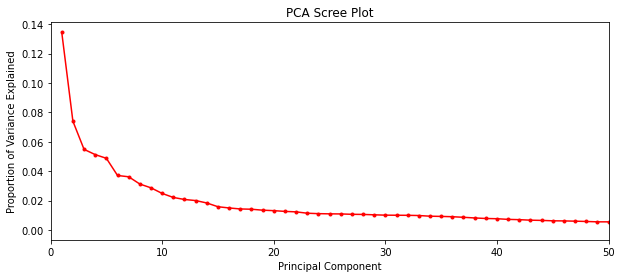

In [10]:
#Fit the PCA to the scaled data, and plot the Scree Plot to determine how many components to keep
pca = PCA()
bankruptcy_pca = pca.fit(X_train_scaled)

fig, ax = plt.subplots(figsize=(10,4))
y_pca = pca.explained_variance_ratio_
x_pca = np.arange(len(y_pca))+1
plt.plot(x_pca, y_pca, 'r.-')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xlim([0,50]) #image only the first 50 components to save space
plt.show()

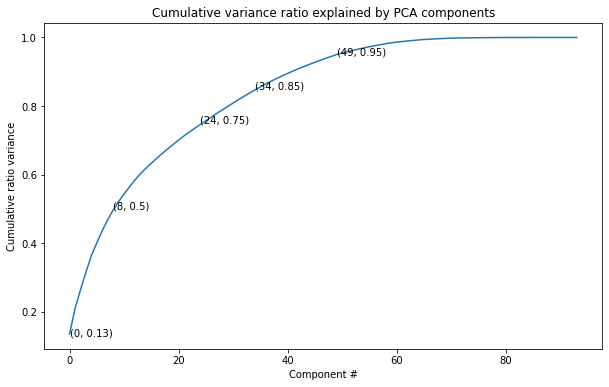

In [11]:
#Plot the cumulative variance ratio with number of components.

_=plt.subplots(figsize=(10,6))
_=plt.plot(bankruptcy_pca.explained_variance_ratio_.cumsum())
_=plt.xlabel('Component #')
_=plt.ylabel('Cumulative ratio variance')
_=plt.title('Cumulative variance ratio explained by PCA components')

points_of_interest = [0,8,24,34,49] #pick several point to annotate.
B = []
for i in points_of_interest:
    C = pca.explained_variance_ratio_.cumsum()[i]
    B.append(round(C,2))
A= points_of_interest

for xy in zip(A, B):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

From the scree plot, we see an elbow at PCs 3 and 6, but from the cumulative variance ratio, we know that keeping just 6 PCs does not even explain up to 50% of the variance in the data.

From the cumulative variance ratio plot, we see that 9 components explain 50% of the variance, 25 explain 75%, 35 explain 85%, and 50 explain 95% of the variance. We will proceed with 50 components.

In [12]:
#Use PCA to reduce from 94 to 50 components
pca_50 = PCA(n_components=50)
X_train_pca = pca_50.fit_transform(X_train_scaled) #fit/transform only on the training set
X_test_pca = pca_50.transform(X_test_scaled) # transform the test set
print('The explained variance of the first 50 PCs:', round(pca_50.explained_variance_ratio_.cumsum()[-1]*100,2),'%')

#Check that it has indeed been reduced to 50 features
print(X_train_pca.shape, X_test_pca.shape)

The explained variance of the first 50 PCs: 95.04 %
(4773, 50) (2046, 50)


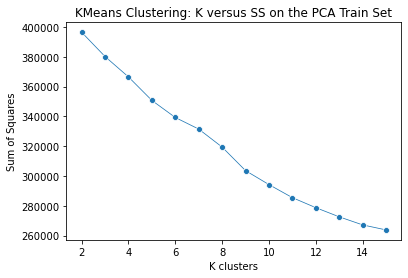

In [13]:
#Plot the KMeans inertia against n_components, and use the elbow method to select number of clusters.
#Here we run KMeans against the PCA transformed train data
x_ss = []
y_ss = []

for n in range(2,16):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X_train_pca)
    x_ss.append(n)
    y_ss.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.

_=plt.xlabel('K clusters')
_=plt.ylabel('Sum of Squares')
_=plt.title('KMeans Clustering: K versus SS on the PCA Train Set')
_=sns.lineplot(x_ss,y_ss, marker='o', size=100, legend=False)

#looking at the graph below, the elbow appears to occus at K=7 and K=11

In [14]:
#Since it's not clear whether to select K=7 or K=11, find the max silhouette score for that range of numbers.
cluster = []
score = []

range_n_clusters = np.arange(7,15) #start at 7, where we see the first elbow
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    cluster.append(n_clusters)
    score.append(silhouette_avg)

max_score = max(score)
max_score_index = score.index(max_score)
max_score_cluster = cluster[max_score_index]
print("The max silhouette score for the PCA-transformed train set is: ", max_score, " with n_clusters: ", max_score_cluster)


The max silhouette score for the PCA-transformed train set is:  0.08411927631578847  with n_clusters:  14


Silhouette scores below 0.25 is weak and may be artificial, so we will disregard the result from the silhouette score and instead focus on the elbow. We proceed with n_clusters=7.

In [15]:
#Calculate the number of data points and bankrupt points in each cluster

n_clusters=7

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train_pca)
array = kmeans.labels_
x_points = []
y_points = []
for i in range(n_clusters):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

    
df_klabels = pd.DataFrame(X_train_pca) #make a copy of the train set
df_klabels['labels'] = kmeans.labels_ #append the cluster labels to train set
df_klabels['bankrupt'] = y_train.reset_index(drop=True) #add the company bankruptcy status

#find how many of the bankrupt data matches each label
df_bankrupt = df_klabels[df_klabels['bankrupt'] == 1] #make subset df containing only bankrupt companies
x_points_bankrupt = []
y_points_bankrupt = []
for i in range(n_clusters):
    x_points_bankrupt.append(i)
    y_points_bankrupt.append(np.count_nonzero(df_bankrupt.labels == i))


print(x_points)
print(y_points)
print(y_points_bankrupt)


#What percent of each label is in the bankrupt class?
for i in x_points:
    if y_points[i] == 0:
         print('Label:', i, ', Percent Bankrupt: 0%')
    else:
        print('Label:', i, ', Percent Bankrupt:', round(y_points_bankrupt[i]/y_points[i]*100,2), '%')

[0, 1, 2, 3, 4, 5, 6]
[322, 1229, 395, 3, 3, 1677, 1144]
[0, 20, 80, 0, 1, 49, 4]
Label: 0 , Percent Bankrupt: 0.0 %
Label: 1 , Percent Bankrupt: 1.63 %
Label: 2 , Percent Bankrupt: 20.25 %
Label: 3 , Percent Bankrupt: 0.0 %
Label: 4 , Percent Bankrupt: 33.33 %
Label: 5 , Percent Bankrupt: 2.92 %
Label: 6 , Percent Bankrupt: 0.35 %


From the clustering, we see that 143 (out of a total of 154) bankrupt companies are clustered under labels 4 and 5.

In [16]:
#Use the kmeans to predict the labels for the test set.
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train_pca)
X_test_labels = kmeans.predict(X_test_pca)
X_test_kmeans = pd.DataFrame(X_test_pca) #make a df copy of the test set so we can append the labels
X_test_kmeans['labels'] = X_test_labels

X_test_kmeans.shape
#as expected, we have our 50 components, plus 1 column of labels.

(2046, 51)

In [17]:
#using the df from earlier, drop the "bankrupt" column so that we have our 50 PCs and the KMeans labels.
X_train_kmeans = df_klabels.drop(columns=['bankrupt'])
X_train_kmeans.shape

(4773, 51)

In [18]:
#One-hot-encode the "labels" column for both the X_test_kmeans and X_train_kmeans dataframes.
X_train_kmeans_one_hot = pd.get_dummies(X_train_kmeans, columns=['labels'])
X_test_kmeans_one_hot = pd.get_dummies(X_test_kmeans, columns=['labels'])

#Since we have 7 clusters, and 50 PCs, we expect a total of 57 features.
X_train_kmeans_one_hot.shape, X_test_kmeans_one_hot.shape

((4773, 57), (2046, 57))

In [19]:
#Interestingly, X_test_kmeans_one_hot has 2 fewer features than that of X_train.
#Perhaps this is due to fewer kmeans labels. Let's check the unique values of X_test_labels.
np.unique(X_test_labels)

array([0, 1, 2, 3, 4, 5, 6])

In [20]:
#There is indeed fewer labels in the test data. X_test is missing labels 3 and 6.  
#Add labels 3 and 6 so that X_test and X_train are the same shape.

X_test_kmeans_one_hot['labels_3'] = 0
X_test_kmeans_one_hot['labels_6'] = 0


#sort the columns so that the labels_# are in order.
sorted_columns = [         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,         17,
               18,         19,         20,         21,         22,         23,
               24,         25,         26,         27,         28,         29,
               30,         31,         32,         33,         34,         35,
               36,         37,         38,         39,         40,         41,
               42,         43,         44,         45,         46,         47,
               48,         49, 'labels_0', 'labels_1', 'labels_2', 'labels_3',
       'labels_4', 'labels_5', 'labels_6']

X_test_kmeans_one_hot = X_test_kmeans_one_hot.reindex(sorted_columns, axis=1)


#Check that this worked:
X_test_kmeans_one_hot.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,labels_0,labels_1,labels_2,labels_3,labels_4,labels_5,labels_6
0,-0.779295,1.988687,-0.565055,-1.834919,-1.125494,-0.704060,1.346929,0.686589,0.137908,2.488554,...,-0.445269,-0.228419,0.042342,0,1,0,0,0,0,0
1,-1.364860,-1.320986,0.110306,0.209501,0.697517,-0.069458,0.144384,-0.736340,0.751660,-0.317079,...,0.379260,0.851112,-0.082130,0,0,0,0,0,0,0
2,5.274151,-2.585705,0.045713,1.925854,-0.418434,0.267947,0.626951,-0.390227,-0.224814,-1.905657,...,0.648599,0.943784,-0.310702,0,0,1,0,0,0,0
3,-2.650954,1.625690,-0.577226,0.719897,-2.757376,0.059717,0.652029,0.043863,-0.035776,2.137510,...,-0.020610,0.571730,0.093854,0,1,0,0,0,0,0
4,-10.935020,0.390758,-0.364124,0.994966,2.044332,0.465337,-1.455515,0.879704,-1.027342,-0.847959,...,-0.107238,-1.147126,0.156328,1,0,0,0,0,0,0


At this point we have successfully preprocessed the X_train and X_test data with Scaling (np.log1p and StandardScaler), PCA (50 components), and K-Means Clustering (7 clusters). 

The training data is now ready for SMOTE upsampling.

## 4.6 Upsampling with SMOTE<a id='4.6'></a>

As we have already seen, our dataset has a major class imbalance; only 3.23% of our dataset are bankrupt companies while the other 96.77% are non-bankrupt companies. For several types of classifiers, rebalancing the dataset can significantly improve the performance of the classifier.

There are several ways to handle class imbalance. The most naive method is to generate new samples by resampling the minority class with sample replacement, but this can lead to overfitting. An alternative method is to synthesize new data using Synthetic Minority Oversampling TEchnique (SMOTE).

SMOTE works by introducing synthetic examples, rather than resampling. Based on a distance metric, several nearest neighbors of the same class are selected and their features interpolated to generate new datapoints.

In this section, we will use SMOTE to upsample our minority class in the training set.

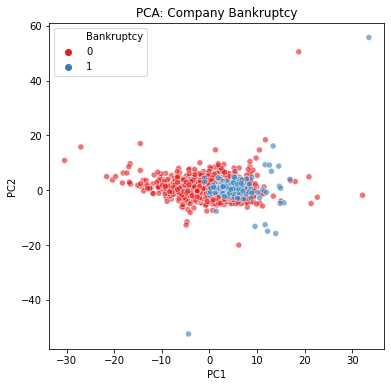

In [30]:
#plot the data prior to doing SMOTE

#reorg the data so that the minority class is plotted last (i.e. easier to see visually)
clusters_bankruptcy = pd.concat([X_train_kmeans_one_hot, pd.DataFrame({'Bankruptcy':y_train.reset_index(drop=True)})], axis=1)
clusters_bankruptcy_sorted = clusters_bankruptcy.sort_values(by=['Bankruptcy'])

plt.figure(figsize = (6,6))
sns.scatterplot(clusters_bankruptcy_sorted.iloc[:,0],clusters_bankruptcy_sorted.iloc[:,1],
                hue=clusters_bankruptcy_sorted.Bankruptcy, palette='Set1', alpha=0.6).set_title('PCA: Company Bankruptcy')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [22]:
# transform the dataset
smote = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1) #default k_neighbors is 5
X_smote, y_smote = smote.fit_resample(X_train_kmeans_one_hot, y_train.reset_index(drop=True))

In [25]:
#Check to see if we have 50/50 class split for y_smote
y_smote.sum()/y_smote.shape[0]

0.5

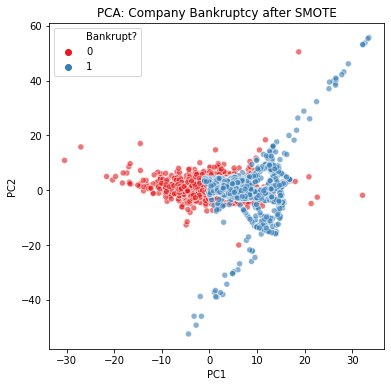

In [31]:
#plot the data after doing SMOTE

plt.figure(figsize = (6,6))
sns.scatterplot(X_smote.iloc[:,0],X_smote.iloc[:,1],
                hue=y_smote, palette='Set1', alpha=0.6).set_title('PCA: Company Bankruptcy after SMOTE')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

How do we decide how many k_neighbors to select for SMOTE? We can do a gridsearch using varying values of k_neighbors, evaluate it against a model (such as RandomForestClassifier) and select the k_neighbors that leads to the largest ROC_AUC value. ROC_AUC is suitable in this case since it is being evaluated over the post-SMOTE data, so the classes are balanced. The ROC measure the FPR against the TPR.

In [40]:
#The following code snippet is adapted from the following article:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# values to evaluate
k_values = np.arange(15)+1 #ranges from 1 to 15 neighbors
for k in k_values:
    
    # define pipeline
    model = RandomForestClassifier(random_state=42)
    over = SMOTE(k_neighbors=k)
#     under = RandomUnderSampler(sampling_strategy=0.5)
#     steps = [('over', over), ('under', under), ('model', model)]
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(pipeline, X_train_kmeans_one_hot, y_train.reset_index(drop=True), scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.5f' % (k, score))

> k=1, Mean ROC AUC: 0.90615
> k=2, Mean ROC AUC: 0.90944
> k=3, Mean ROC AUC: 0.91061
> k=4, Mean ROC AUC: 0.90877
> k=5, Mean ROC AUC: 0.91045
> k=6, Mean ROC AUC: 0.91047
> k=7, Mean ROC AUC: 0.90587
> k=8, Mean ROC AUC: 0.91191
> k=9, Mean ROC AUC: 0.91211
> k=10, Mean ROC AUC: 0.91215
> k=11, Mean ROC AUC: 0.91221
> k=12, Mean ROC AUC: 0.90974
> k=13, Mean ROC AUC: 0.91138
> k=14, Mean ROC AUC: 0.91024
> k=15, Mean ROC AUC: 0.91197


From the grid search, we see that k=9, 10, and 11 have the highest ROC curves, though all of them seem to perform similarly well (all of them are around 0.91).

We select k=10 and re-do the SMOTE.

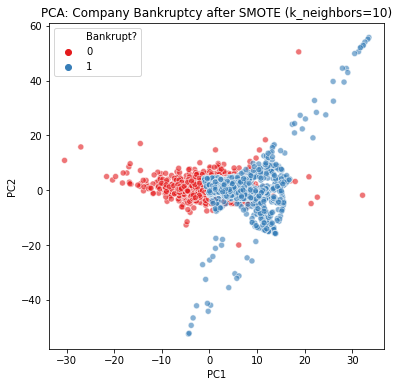

In [41]:
# transform the dataset
smote = SMOTE(random_state=42, k_neighbors=10, n_jobs=-1) #default k_neighbors is 5
X_smote, y_smote = smote.fit_resample(X_train_kmeans_one_hot, y_train.reset_index(drop=True))

#plot the data after doing SMOTE

plt.figure(figsize = (6,6))
sns.scatterplot(X_smote.iloc[:,0],X_smote.iloc[:,1],
                hue=y_smote, palette='Set1', alpha=0.6).set_title('PCA: Company Bankruptcy after SMOTE (k_neighbors=10)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

### 4.6.1 Exporting the Data<a id='4.6.1'></a>

Now that we have finished our SMOTE oversampling, we can export our train set. Our test set also has labels from K-Means Clustering, so we can export that too.

In [46]:
#Export our train/test data. 
#Train set has been labeled with k-means clusters, and oversampled with SMOTE.
#Test set has been labeled with k-means clusters.

X_smote.to_csv('X_train_smote.csv')
y_smote.to_csv('y_train_smote.csv')

X_test_kmeans_one_hot.to_csv('X_test_kmeans.csv') #this is our modified test set that has one-hot encoded cluster labels
# y_test.to_csv('y_test.csv') #this one has already been exported

## 4.7 Baseline Model: Logistic Regression<a id='4.7'></a>

For classification problems, logistic regression is one of the simplest methods. We use logistic regression here as a "baseline" model, allowing us to see what our evaluation metrics may be. We will look at the confusion matrix, accuracy, F1-score, precision, and recall to evaluate the performance of the model.

We will also do a simple comparison between the results from our unprocessed train/test data (X_train, y_train, X_test, y_test) and post-processed train-test data (X_smote, y_smote, X_test_kmeans_one_hot, y_test).

In [64]:
#Run a RandomizedSearchCV for hyperparameter tuning on LogisticRegression.
#Train on X_smote and y_smote.

start_time = time.time()

c = np.logspace(-4, 3, num=40, base=10.0, dtype=np.float64)  # make a list of C parameters, from 0.0001 to 1000.
l1_ratio = np.linspace(0, 1, num=21) #make a list of l1_ratio parameters, from 0 to 1.
parameters= {'C':list(c), 
             'fit_intercept':[True, False], 
             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
             'multi_class':['auto', 'ovr', 'multinomial'], 
             'l1_ratio':list(l1_ratio) #only valid when penalty is elasticnet
            } 

lr = LogisticRegression(random_state=42, penalty = 'elasticnet', n_jobs=-1)
clf = sklearn.model_selection.RandomizedSearchCV(lr, 
                                                 param_distributions=parameters, 
                                                 n_iter=500,
                                                 cv=10, 
                                                 n_jobs=-1, 
                                                 random_state=42
                                                )
clf.fit(X_smote, y_smote)
print("Best Estimator:", clf.best_estimator_)
print()
print("Best Params:", clf.best_params_)
print()
print("Best Score:", clf.best_score_)
print()

y_pred = clf.predict(X_test_kmeans_one_hot)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression: Accuracy=%.4f' % (ac))
print('Logistic Regression: f1-score=%.4f' % (f1))
print('Logistic Regression: precision=%.4f' % (pr))
print('Logistic Regression: recall=%.4f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan 0.88990927        nan        nan        nan        nan
        nan        nan        nan        nan 0.87572885        nan
        nan        nan        nan        nan        nan        nan
        nan 0.89889477        nan        nan 0.89034217 0.89889477
        nan        nan        nan        nan 0.89001749        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.84855872 0.89044993        nan        nan 0.86977565
        nan        nan        nan        nan        nan        nan
 0.86825921        nan        nan        nan        nan        nan
        nan        nan 0.89856939        nan        nan        nan
        nan        nan        nan      

Best Estimator: LogisticRegression(C=0.5878016072274912, fit_intercept=False, l1_ratio=0.5,
                   multi_class='multinomial', n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga')

Best Params: {'solver': 'saga', 'multi_class': 'multinomial', 'l1_ratio': 0.5, 'fit_intercept': False, 'C': 0.5878016072274912}

Best Score: 0.9000851261414642

Logistic Regression: Accuracy=0.8773
Logistic Regression: f1-score=0.9119
Logistic Regression: precision=0.1731
Logistic Regression: recall=0.7424

Confusion Matrix without Normalization
[[1746  234]
 [  17   49]]

Confusion Matrix with Normalization
[[0.88 0.12]
 [0.26 0.74]]

Total Time: 150.9428653717041


C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [65]:
#Do the same as before, except using X_train, y_train, X_test, y_test.

start_time = time.time()

c = np.logspace(-4, 3, num=40, base=10.0, dtype=np.float64)  # make a list of C parameters, from 0.0001 to 1000.
l1_ratio = np.linspace(0, 1, num=21) #make a list of l1_ratio parameters, from 0 to 1.
parameters= {'C':list(c), 
             'fit_intercept':[True, False], 
             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
             'multi_class':['auto', 'ovr', 'multinomial'], 
             'l1_ratio':list(l1_ratio) #only valid when penalty is elasticnet
            } 

lr = LogisticRegression(random_state=42, penalty = 'elasticnet', n_jobs=-1)
clf = sklearn.model_selection.RandomizedSearchCV(lr, 
                                                 param_distributions=parameters, 
                                                 n_iter=500,
                                                 cv=10, 
                                                 n_jobs=-1, 
                                                 random_state=42
                                                )
clf.fit(X_train, y_train)
print("Best Estimator:", clf.best_estimator_)
print()
print("Best Params:", clf.best_params_)
print()
print("Best Score:", clf.best_score_)
print()

y_pred = clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression: Accuracy=%.4f' % (ac))
print('Logistic Regression: f1-score=%.4f' % (f1))
print('Logistic Regression: precision=%.4f' % (pr))
print('Logistic Regression: recall=%.4f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time:', time.time() - start_time)

C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan 0.96228871        nan        nan        nan        nan
        nan        nan        nan        nan 0.96228871        nan
        nan        nan        nan        nan        nan        nan
        nan 0.96228871        nan        nan 0.96270712 0.96228871
        nan        nan        nan        nan 0.96228871        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.96270712 0.96228871        nan        nan 0.96228871
        nan        nan        nan        nan        nan        nan
 0.96228871        nan        nan        nan        nan        nan
        nan        nan 0.96228871        nan        nan        nan
        nan        nan        nan      

Best Estimator: LogisticRegression(C=0.04923882631706741, l1_ratio=0.8,
                   multi_class='multinomial', n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga')

Best Params: {'solver': 'saga', 'multi_class': 'multinomial', 'l1_ratio': 0.8, 'fit_intercept': True, 'C': 0.04923882631706741}

Best Score: 0.9627071217424102

Logistic Regression: Accuracy=0.9619
Logistic Regression: f1-score=0.9489
Logistic Regression: precision=0.0000
Logistic Regression: recall=0.0000

Confusion Matrix without Normalization
[[1968   12]
 [  66    0]]

Confusion Matrix with Normalization
[[0.99 0.01]
 [1.   0.  ]]

Total Time: 138.25750136375427


C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In our baseline model, we already see differences in the results based on whether the training data was processed or not.

For the processed data (i.e. scaled, reduced with PCA, labeled with K-Means clustering), we receive the following results:
* __Best Estimator:__ LogisticRegression(C=0.5878016072274912, fit_intercept=False, l1_ratio=0.5, multi_class='multinomial', n_jobs=-1, penalty='elasticnet', random_state=42, solver='saga')
* __Best Params:__ {'solver': 'saga', 'multi_class': 'multinomial', 'l1_ratio': 0.5, 'fit_intercept': False, 'C': 0.5878016072274912}
* __Best Score:__ 0.9001
* __Accuracy:__ 0.8773
* __F1-Score:__ 0.9119
* __Precision:__ 0.1731
* __Recall:__ 0.7424
* Confusion Matrix without Normalization
        [[1746  234]
         [  17   49]]
* Confusion Matrix with Normalization
        [[0.88 0.12]
         [0.26 0.74]]
 
 
For the unprocessed data (i.e. the data from the train/test split), we receive the following results:
* __Best Estimator:__ LogisticRegression(C=0.04923882631706741, l1_ratio=0.8, multi_class='multinomial', n_jobs=-1, penalty='elasticnet', random_state=42, solver='saga')
* __Best Params:__ {'solver': 'saga', 'multi_class': 'multinomial', 'l1_ratio': 0.8, 'fit_intercept': True, 'C': 0.04923882631706741}
* __Best Score:__ 0.9627
* __Accuracy:__ 0.9619
* __F1-Score:__ 0.9489
* __Precision:__ 0.0000
* __Recall:__ 0.0000
* Confusion Matrix without Normalization
        [[1968   12]
         [  66    0]]
* Confusion Matrix with Normalization
        [[0.99 0.01]
         [1.   0.  ]]


From the results, we see that both models had some similar hyperparameters. 'multi_class': 'multinomial' and 'solver': 'saga' was selected for both models. 'l1_ratio', 'fit_intercept', and 'C' were different between the two.

What is most striking are the evaluation metrics. At first the processed data appears have lower accuracy and F1-score than that of the unprocessed data. But precision and recall are both 0 for the unprocessed data, because there was not a single bankrupt company that was sorted into the correct class. It is as if the model simply placed every data point into the majority class.

What we can see from this exercise is that, at least against a simple model like LogisticRegression(), using SMOTE to upsample our minority class greatly improves the performance of the model.

## 4.8 Summary and Next Steps<a id='4.8'></a>

__Summary:__

In this notebook, we did the following:
1. We conducted a 70/30 train/test split.
2. We scaled and processed the training data in the same way as we did in the previous notebook: scale with np.log1p and StandardScaler, dimensionality reduction with PCA, and generate labels with K-Mean Clustering. The K-Means cluster labels were also one-hot-encoded.
    * We used n_clusters=7 for K-Means clustering.
    * Note: all transformations were fit to the training data, and transformed both the train and test sets. Care was taken to not allow anything to be fitted on the test data, as that would pollute the test data.
3. We exported the unprocessed and processed data.
    * X_train, y_train, X_test, and y_test were exported as unprocessed data.
    * X_smote, y_smote, X_test_kmeans were exported as processed 
4. We upsampled the minority class (bankrupt companies) with Synthetic Minority Oversampling TEchnique (SMOTE).
    * We used GridSearchCV to select k=10 neighbors when conducting SMOTE.
5. We ran Logistic Regression as a baseline model against the training data, and did hyperparameter tuning to optimize the model before comparing the evaluation metrics between the datasets.

In the results of our baseline model, we saw that without SMOTE to upsample our minority class, the model sorted everything into the majority class, resulting in 0 true positives. A more robust classifier (such as RandomForest or XG Boost) may be able to make better predictions on the unprocessed data. But it is clear that using SMOTE to upsample our minority class greatly improves the performance of the baseline model.



__Next Steps:__

In the next notebook, "Step 5 - Modeling", we will develop a pipeline that scales the data, reduces the dimensions with PCA, labels with KMeans, upsamples with SMOTE, and models the data with either Logistic Regression (as a baseline), Random Forest, or XG Boost. 

We will conduct hyperparameter tuning on the pipeline, and compile a table of results.